Silent substitution problems
============================

Silent substitution stimuli typically take the form of pulses or temporal modulations of photoreceptor-directed contrast presented against a background spectrum to which an observer has adapted. 

The background spectrum serves to maintain a set pattern of photoreceptor activations and the modulation spectrum increases activation of the targeted photoreceptor(s) without altering activation of the others. 

Before getting started with silent substitution you will need a calibrated [forward model of your stimulation device](03b_stimulation_devices.ipynb) that can predict the spectral output for any combination of settings. With that in place, you are ready to solve silent substitution problems. 

`pysilsub.problems.SilentSubstitutionProblem`
---------------------------------------------

This class serves as the interface for defining, solving, and visualising silent substitution problems. It extends `pysilsub.devices.StimulationDevice` with [properties](https://realpython.com/python-property/) (i.e., managed class attributes), and methods for finding and plotting solutions.

Instances are created in the same ways as `StimulationDevice` instances, so for convenience let's use the `.from_package_data(...)` constructor described [here](03b_stimulation_devices.ipynb#Package-data). 


In [1]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

ssp = SSP.from_package_data('STLAB_1_York')

The properties of a `SilentSubstitutionProblem` are:

  - `background` - the background spectrum
  - `ignore` - which photoreceptors to ignore
  - `minimize` - which photoreceptors to minimize
  - `modulate` - which photoreceptors to modulate
  - `target_contrast` - desired target contrast as a percentage of the background spectrum
  
For more details on any of the above, just ask:

In [2]:
ssp.ignore?

Type:        property
String form: <property object at 0x7fb25bcd6430>
Docstring:  
Photoreceptor(s) to be ignored.

Setting the *ignore* property internally conditions the silent
substitution problem such that the specified photoreceptor(s) will be
ignored by the solvers (enabling them to find more contrast). In most
cases *ignore* will be set to ['rh'], because it is considered safe
practice to ignore rods when stimuli are in the photopic range
(>300 cd/m2)::

    problem.ignore = ['rh']

But you could also choose to ignore rods and melanopsin::

    problem.ignore = ['rh', 'mel']

In the event that you don't want to ignore any photoreceptors, you must
still pass::

    problem.ignore = [None]

Setting the *ignore* property is an essential step for conditioning a
silent substitution problem.

Raises
------
SilSubProblemError if ignore not specified.

Returns
-------
ignore : [None] or list of str
    Photoreceptors to be ignored.


Defining a problem
------------------

Problems are defined by setting the required/desired properties. The `ignore`, `modulate` and `minimize` properties **must** be set and should together account for all photoreceptors ('sc', 'mc', 'lc', 'rh', 'mel'). The `background` and `target_contrast` properties may need to be set, depending on the constraints of your research question and which solver you intend to use.

In [2]:
print(f'Retinal photoreceptors:\n{ssp.observer.photoreceptors}\n')

# These properties *must* be set
ssp.ignore = ['rh']
ssp.modulate = ['sc']
ssp.minimize = ['mc', 'lc', 'mel']

# These properties may need to be set, 
# depending on which solver you intend to use
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .2
ssp.print_problem()

Retinal photoreceptors:
['sc', 'mc', 'lc', 'rh', 'mel']

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['mc', 'lc', 'mel']
Modulating: ['sc']
Target contrast: [ 0.2]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Here we have said that we want to modulate S-cone contrast by 20% relative to a background of all primaries at half-maximum, whilst ignoring the rod photoreceptors and minimising changes in activation of M-cones, L-cones and melanopsin. 

Finding a solution
------------------

After defining a problem it is easy to find a solution, providing one actually exists within the gamut of the device. 

Two solvers are available for this. For some background on these methods, further details on implementation, and a variety of use cases, please refer to the [worked examples](05_examples.rst).

#### `.linalg_solve()` 
This method uses linear algebra for unidirectional scaling of the primaries and works only if the `background` and `target_contrast` properties have been set.

In [3]:
linalg_solution = ssp.linalg_solve()
print(linalg_solution)

Primary
0    0.690321
1    0.691415
2    0.466177
3    0.408474
4    0.340682
5    0.481743
6    0.592777
7    0.482589
8    0.401621
9    0.457403
dtype: float64


#### `.optim_solve(...)` 
This method uses numerical optimisation methods from `scipy.optimize`. If the `target_contrast` property was not set, the solver aims to maximise contrast. If the `background` property was not set, the background spectrum will also be optimised. 

In [4]:
optim_solution = ssp.optim_solve(**{'options':{'disp':False}})
print(optim_solution.x)

> Performing local optimization with SLSQP.
[ 0.18839776  0.94905427  0.79360254  0.22002221  0.27236013  0.6421311
  0.35241468  0.76237495  0.04011788  0.03181959]


Visualising a solution
----------------------

Having found a solution, you will probably want to see what it looks like. 

`.plot_solution(...)` makes a nice plot showing the predicted background and modulation spectra alongside their CIE *xy* chromaticity coordinates and *a*-opic irradiance. 

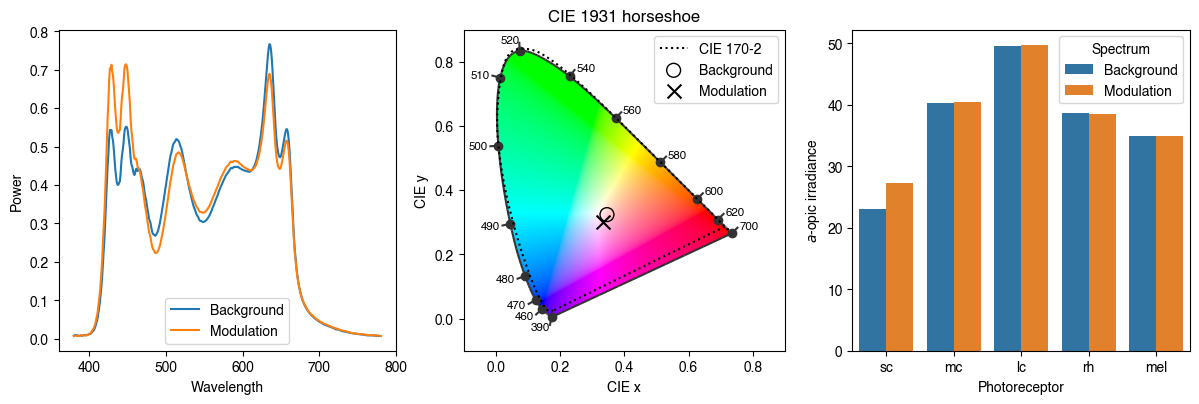

In [5]:
# Linear algebra solution
fig = ssp.plot_solution(linalg_solution)

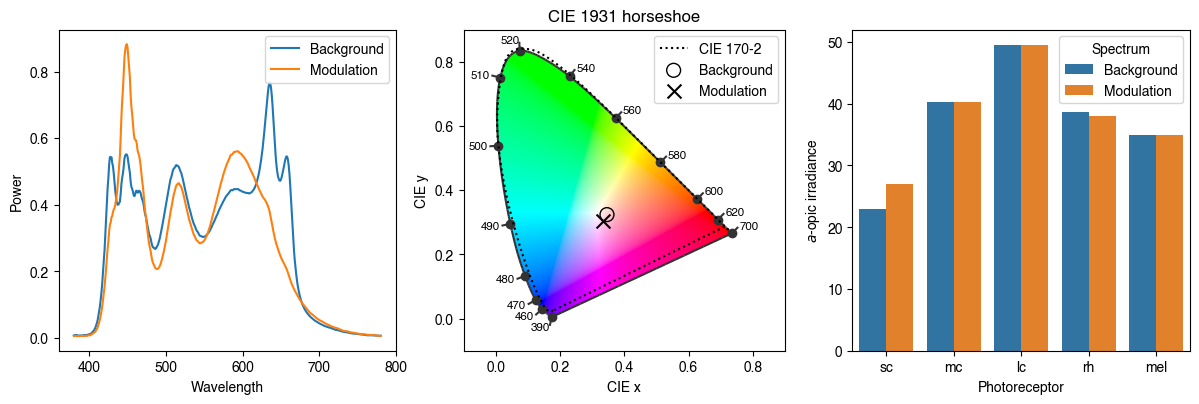

In [6]:
# Optimisation solution
fig = ssp.plot_solution(optim_solution.x)

Note that the above solutions are somewhat different due to the contrasting approaches of the solvers, but they achieve the same aim of finding 20% contrast on S-cones relative to the background spectrum without changing activation in the other photoreceptors. 